# COMUNICACION DE RESULTADOS

## Anotación:

**Las funcionalidades de las extenciones de las que hablamos en este notebook ya no están activas, estamos a la espera de que el equipo de desarrollo proporcione una solución** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlalchemy as sa

#Automcompletar rápido
%config IPCompleter.greedy=True

pd.options.display.max_columns = None

con = sa.create_engine('sqlite:///../../02_Datos/01_Originales/airbnb2025.db')

df = pd.read_sql('df_preparado', con = con)

#Minicubo:

metricas = ['precio_total','precio_compra']
dimensiones = ['bedrooms_disc','accommodates_disc','beds_disc','number_of_reviews_disc']

minicubo_precio = df[dimensiones + metricas]

minicubo_precio = minicubo_precio.melt(id_vars=['precio_total','precio_compra'])

minicubo_precio = minicubo_precio.groupby(['variable','value'])[['precio_total','precio_compra']].agg('median')

In [2]:
con = sa.create_engine('sqlite:///../../02_Datos/01_Originales/airbnb2025.db')

df = pd.read_sql('df_preparado', con = con)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25913 entries, 0 to 25912
Data columns (total 63 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   index                                         25913 non-null  int64         
 1   id                                            25913 non-null  int64         
 2   name                                          25913 non-null  object        
 3   host_response_time                            25913 non-null  object        
 4   host_is_superhost                             25913 non-null  object        
 5   host_verifications                            25913 non-null  object        
 6   host_has_profile_pic                          25913 non-null  object        
 7   host_identity_verified                        25913 non-null  object        
 8   neighbourhood_cleansed                        25913 non-null  obje

## CONTEXTO DEL ANALISIS

La empresa ha seleccionado la ciudad de Madrid como candidata para buscar inmuebles en los que invertir con el objetivo de obtener rentabilidad mediante alquiler turístico.

Para ello, antes de poner al equipo de valoraciones a buscar oportunidades, la dirección ha encargado al equipo de Data Science un análisis de Discovery que permita identificar estrategias o líneas de trabajo que ayuden a dirigir la actuación del equipo de valoraciones.

## OBJETIVOS

* Analizar las fuentes de datos públicas disponibles
* Para encontrar insights que ayuden a entender las características del mercado en esta ciudad
* Y guíen el trabajo de búsqueda del equipo de valoraciones
* Especialmente en cuanto a los principales ejes: precio del alquiler, niveles de ocupación y precio de compra

## CONCLUSIONES EJECUTIVAS

* Se han localizado 5 barrios en los que centrar la búsqueda
* Se recomienda buscar inmuebles con un habitación que permitan alojar 3 huéspedes
* Se recomienda buscar inmuebles que estando en uno de los barrios identificados no estén necesariamente cerca de puntos de interés
* Se recomienda evaluar el desarrollo de un nuevo producto basado en el alquier para momentos concretos de alto interés deportivo, especialmente en el barrio de San Blas

## DETALLE DE LOS PRINCIPALES RESULTADOS

### Existen 5 barrios con alto potencial de inversión

* Se han localizado 5 barrios que apriori pueden maximizar la relación coste-ingresos
* Además podemos segmentarlos por el tipo calidad del inmueble en el que nos interes invertir en 4 grandes grupos
* Estos son los 10 barrios donde comenzar a buscar oportunidades concretas:
    * Inversión baja <150K: Amposta
    * Inversión media 150K-250K: Arguelles y Cortés
    * Inversión medio-alta 250K-350K: Almagro
    * Inversión alta >350K: Castellana

Exhibit 1.4.1

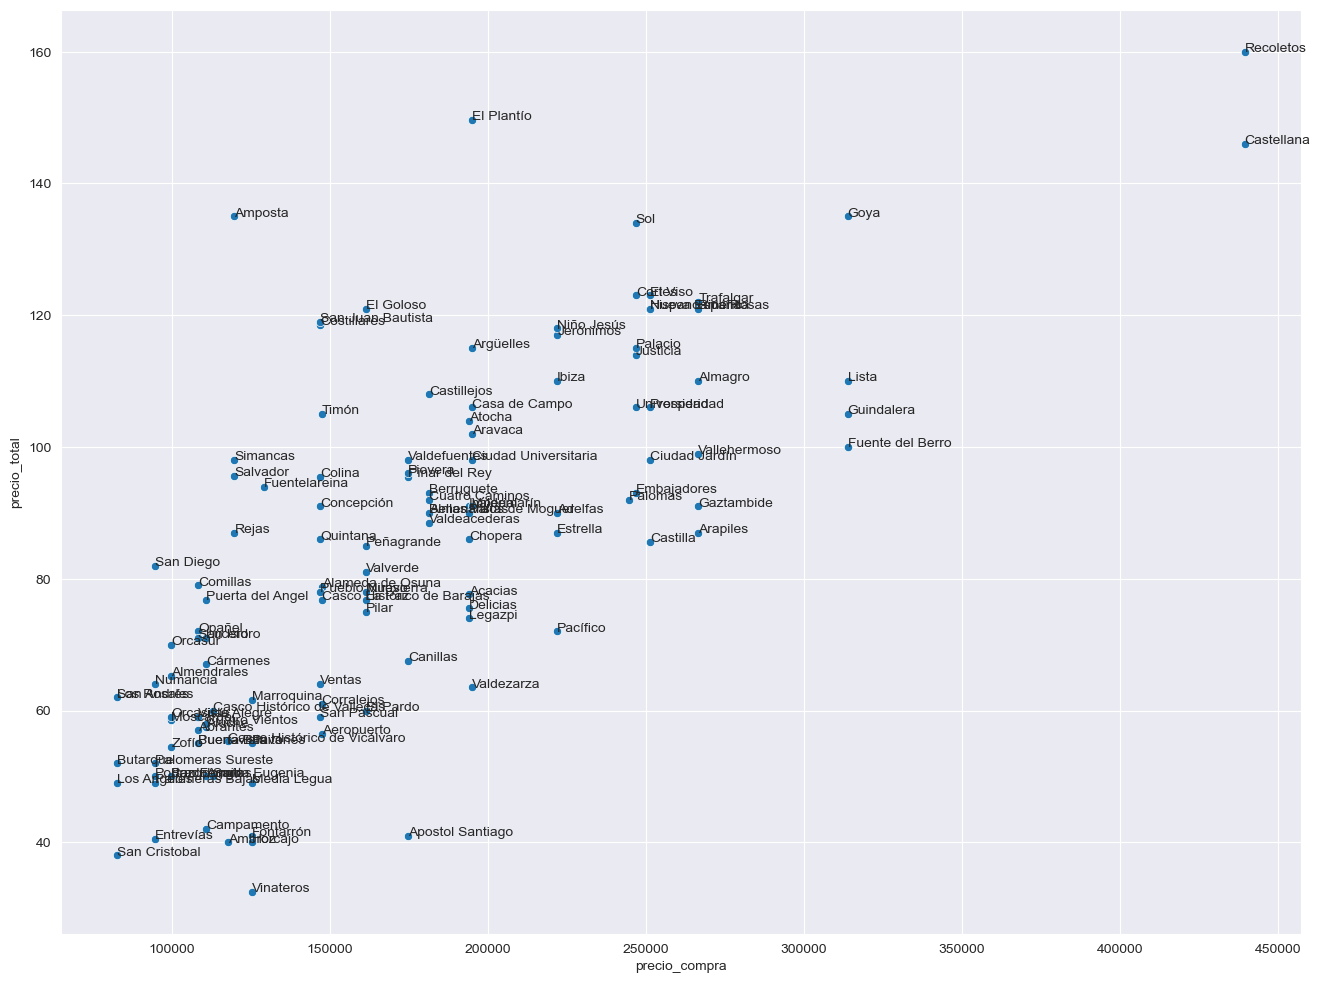

In [4]:
no_incluir = ['Rosas','Arcos','Canillejas','Hellín']

temp = df.groupby('neighbourhood_cleansed')[['precio_total','precio_compra']].median()

temp = temp[~temp.index.isin(no_incluir)]

plt.figure(figsize = (16,12))
sns.set_style('darkgrid')
sns.scatterplot(data = temp, x = 'precio_compra', y = 'precio_total')
#Ponemos las etiquetas
for cada in range(0,temp.shape[0]):
    plt.text(temp.precio_compra.iloc[cada], temp.precio_total.iloc[cada], temp.index[cada])

### Buscar inmuebles de una habitación que permitan 3 huéspedes

* El número de huéspedes que maximiza el precio de compra pagado es de 4

Exhibit 1.4.2

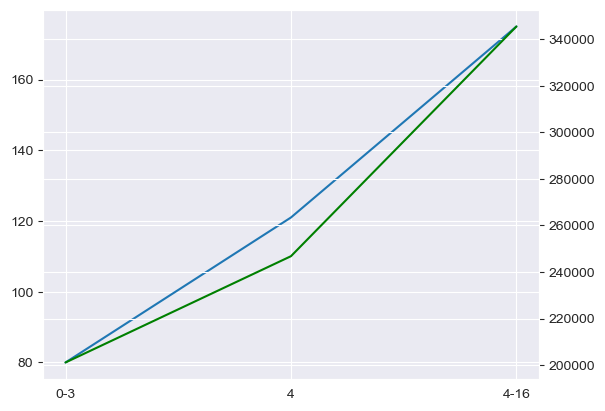

In [5]:
f, ax = plt.subplots()
ax.plot(minicubo_precio.loc['accommodates_disc'].precio_total)
ax2 = ax.twinx()
ax2.plot(minicubo_precio.loc['accommodates_disc'].precio_compra,color = 'green');

### Buscar inmuebles que estando en uno de los barrios identificados no estén necesariamente cerca de puntos de interés

* Previsiblemente tendrán menor precio de compra
* Parece que la cercanía a puntos de interés no tiene un especial impacto sobre el precio del alquiler

Exhibit 1.4.3

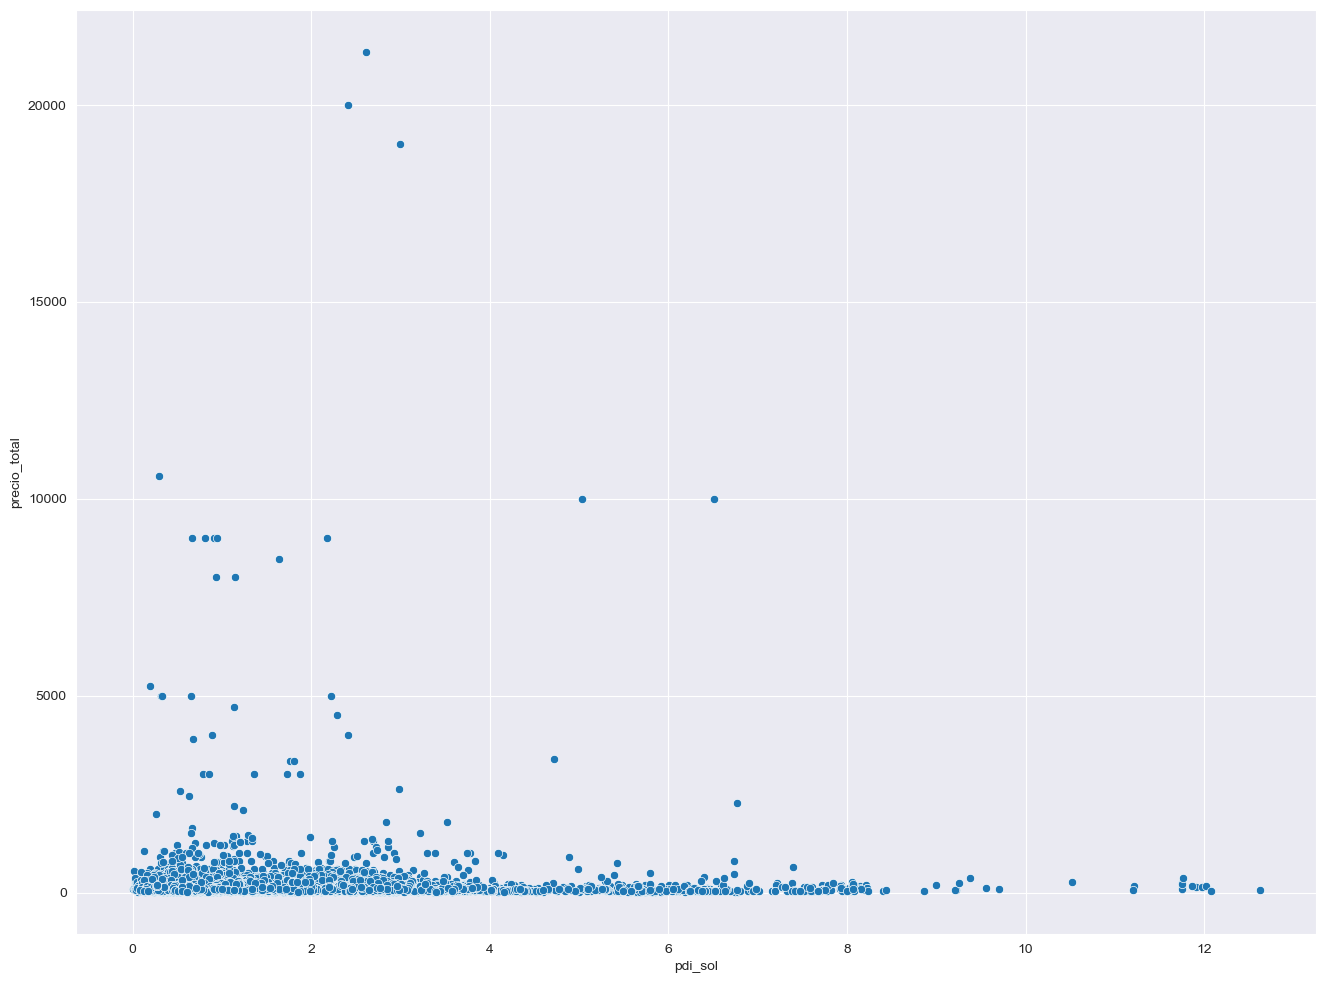

In [6]:
seleccion = df.groupby('neighbourhood_group').pdi_sol.median().sort_values()[0:7].index.to_list()

plt.figure(figsize = (16,12))
sns.scatterplot(data = df.loc[df.neighbourhood_group.isin(seleccion)], x = 'pdi_sol', y = 'precio_total');

### Evaluar el desarrollo de un nuevo producto basado en el alquier para momentos concretos de alto interés deportivo

* Buscar oportunidades en el barrio de San Blas
* Todavía existen muchos alquileres que no están explotando este potencial

Exhibit 1.4.4

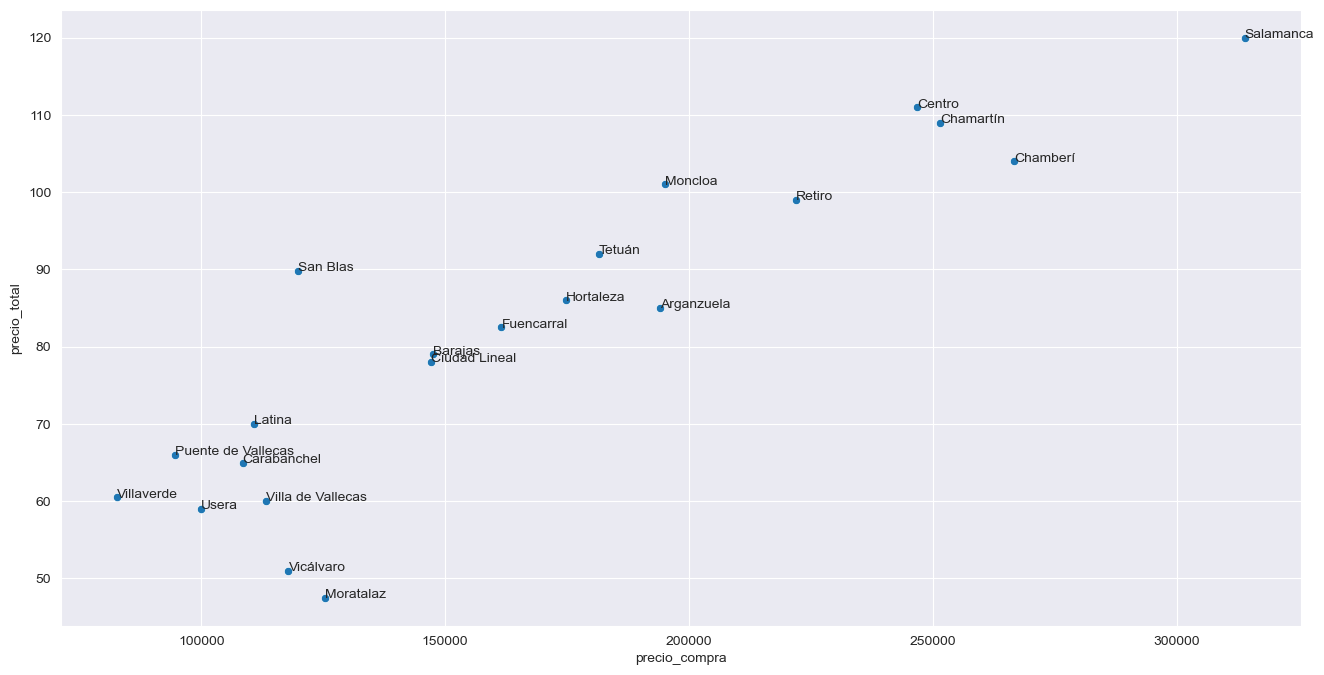

In [7]:
temp = df.groupby('neighbourhood_group')[['precio_total','precio_compra']].median()

plt.figure(figsize = (16,8))
sns.scatterplot(data = temp, x = 'precio_compra', y = 'precio_total')
#Ponemos las etiquetas
for cada in range(0,temp.shape[0]):
    plt.text(temp.precio_compra.iloc[cada], temp.precio_total.iloc[cada], temp.index[cada])

Exhibit 1.4.5

In [8]:
#conda install -c conda-forge folium
import folium

#Cargamos el mapa de la zona
mapa = folium.Map(location=[40.4167278, -3.7033387],zoom_start=12)

#Hacemos una selección de los datos disponibles para cargarlos en el mapa
datos = df[df.neighbourhood_group == 'San Blas'].copy()

#Definimos la variable por la que segmentaremos por colores y y los quartiles de segmentación
datos['precio_total_disc'] = pd.qcut(datos['precio_total'], q = [0, .25, .5, .75, 1.], 
                              labels=['yellow', 'orange', 'blue', 'red'])

#Generamos un bucle que recorra la tabla datos y que vaya extrayendo latitud y longitud y añadiéndolos al mapa
for piso in range(0,len(datos)):
   folium.CircleMarker(
      location = [datos.iloc[piso]['latitude'], datos.iloc[piso]['longitude']],
      popup = datos.iloc[piso]['precio_total'],
      fill=True,
      color = datos.iloc[piso]['precio_total_disc'],
      fill_opacity=1,
      radius = 5
   ).add_to(mapa)

mapa